In [1]:
import pandas as pd
import numpy as numpy
import json 
import os 
import pylab as pl
import urllib
import requests
import sklearn.preprocessing as preprocessing
import statsmodels.formula.api as smf
import statsmodels.api as sm
from scipy.optimize import minimize
from statsmodels.graphics.api import abline_plot
import patsy
from sklearn import preprocessing
import seaborn as sns

import matplotlib.pyplot as plt

%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
path='/Users/katharinevoorhees/CAPSTONe/lehd_by_taxi_zone.csv'

lodes = pd.read_csv(path)

In [3]:
lodes.columns

Index(['Unnamed: 0', 'w_taxi_zone', 'h_taxi_zone', 'S000', 'SA01', 'SA02',
       'SA03', 'SE01', 'SE02', 'SE03', 'SI01', 'SI02', 'SI03'],
      dtype='object')

In [4]:
lodes = lodes[['w_taxi_zone', 'h_taxi_zone', 'S000']]

In [5]:
path='/Users/katharinevoorhees/CAPSTONE/acs_commute_data_by_taxi_zone.csv'

commute = pd.read_csv(path)

commute.head(2)

,Unnamed: 0,taxi_zone,total_total,total_public_transpo,bus,streetcar,subway,total_car_van_truck,car_vt_alone,car_vt_carpooled,bicycle,walked,railroad,ferry,taxi,motorcycle,worked_at_home,other_means
0,0,2.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,1,3.0,13605,5930,1492,41,4197,6450,5476,974,5,683,200,0,86,0,370,81


In [6]:
commute['taxi%'] = (commute['taxi'].astype('int'))/(commute['total_total'].astype('int'))
commute.head()

,Unnamed: 0,taxi_zone,total_total,total_public_transpo,bus,streetcar,subway,total_car_van_truck,car_vt_alone,car_vt_carpooled,bicycle,walked,railroad,ferry,taxi,motorcycle,worked_at_home,other_means,taxi%
0,0,2.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,NaN
1,1,3.0,13605,5930,1492,41,4197,6450,5476,974,5,683,200,0,86,0,370,81,0.006321
2,2,4.0,12434,7039,1723,0,5259,856,717,139,688,3292,57,0,201,28,314,16,0.016165
3,3,5.0,12027,2674,2080,16,212,8914,7589,1325,0,37,37,329,15,0,349,38,0.001247
4,4,6.0,6960,2336,1811,0,292,4023,3528,495,31,228,86,147,19,0,323,0,0.002730


In [7]:
commute_taxi = commute[['taxi_zone','taxi%']]

In [8]:
path='/Users/katharinevoorhees/CAPSTONE/taxi_counts.csv'

taxi_counts = pd.read_csv(path)

taxi_counts.head(2)

,Unnamed: 0,PULocationID,DOLocationID,hour,counts
0,0,1,1,0,1
1,1,1,1,2,3


In [9]:
taxi_counts.shape

(255605, 5)

In [10]:
lodes.shape
lodes['h_taxi_zone']=lodes['h_taxi_zone'].astype('int')
lodes['w_taxi_zone']=lodes['w_taxi_zone'].astype('int')

In [11]:
merged = taxi_counts.merge(lodes, how='left', left_on=['PULocationID','DOLocationID'],
                   right_on=['h_taxi_zone','w_taxi_zone'])

In [12]:
merged.shape

(255605, 8)

In [13]:
nan = merged[merged['h_taxi_zone'].isnull()]
len(nan)

30961

In [14]:
print('about {} OD pairs did not match'.format(30961/24))

about 1290.0416666666667 OD pairs did not match


In [15]:
data = merged.merge(commute_taxi, how='left', left_on='h_taxi_zone',
                   right_on='taxi_zone')
data.shape

(255605, 10)

In [16]:
data.dropna(subset=['h_taxi_zone'], inplace=True)

In [17]:
data.shape

(224644, 10)

In [18]:
data.head()

,Unnamed: 0,PULocationID,DOLocationID,hour,counts,w_taxi_zone,h_taxi_zone,S000,taxi_zone,taxi%
63,63,2,25,21,1,25.0,2.0,2.0,2.0,NaN
65,65,2,233,15,1,233.0,2.0,3.0,2.0,NaN
67,67,3,3,0,1,3.0,3.0,273.0,3.0,0.006321
68,68,3,3,3,1,3.0,3.0,273.0,3.0,0.006321
69,69,3,3,5,1,3.0,3.0,273.0,3.0,0.006321


In [19]:
data['expected_taxi'] = data['S000']*data['taxi%']

In [20]:
data.dropna(subset=['expected_taxi'],inplace=True)
data.head()

,Unnamed: 0,PULocationID,DOLocationID,hour,counts,w_taxi_zone,h_taxi_zone,S000,taxi_zone,taxi%,expected_taxi
67,67,3,3,0,1,3.0,3.0,273.0,3.0,0.006321,1.725689
68,68,3,3,3,1,3.0,3.0,273.0,3.0,0.006321,1.725689
69,69,3,3,5,1,3.0,3.0,273.0,3.0,0.006321,1.725689
70,70,3,3,18,1,3.0,3.0,273.0,3.0,0.006321,1.725689
71,71,3,32,7,2,32.0,3.0,115.0,3.0,0.006321,0.726939


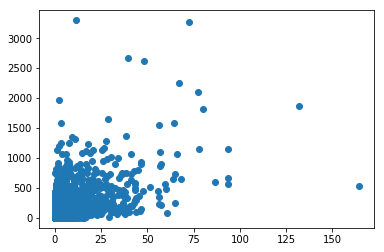

In [21]:
hr8 = data[data['hour'] == 8]

plt.scatter('expected_taxi','counts', data=hr8)
plt.ylim=((0,1500))
plt.xlim=(0,100);

In [32]:
data.corr()

,Unnamed: 0,PULocationID,DOLocationID,hour,counts,w_taxi_zone,h_taxi_zone,S000,taxi_zone,taxi%,expected_taxi
Unnamed: 0,1.000000,0.995333,0.028041,0.008286,0.083455,0.028041,0.995333,-0.046773,0.995333,0.305698,0.104696
PULocationID,0.995333,1.000000,0.018154,0.008051,0.079126,0.018154,1.000000,-0.048063,1.000000,0.312178,0.104346
DOLocationID,0.028041,0.018154,1.000000,0.001587,0.086662,1.000000,0.018154,0.086396,0.018154,0.008986,0.099526
hour,0.008286,0.008051,0.001587,1.000000,0.084050,0.001587,0.008051,-0.012763,0.008051,0.020723,-0.005146
counts,0.083455,0.079126,0.086662,0.084050,1.000000,0.086662,0.079126,0.183798,0.079126,0.177967,0.389772
w_taxi_zone,0.028041,0.018154,1.000000,0.001587,0.086662,1.000000,0.018154,0.086396,0.018154,0.008986,0.099526
h_taxi_zone,0.995333,1.000000,0.018154,0.008051,0.079126,0.018154,1.000000,-0.048063,1.000000,0.312178,0.104346
S000,-0.046773,-0.048063,0.086396,-0.012763,0.183798,0.086396,-0.048063,1.000000,-0.048063,-0.133079,0.564161
taxi_zone,0.995333,1.000000,0.018154,0.008051,0.079126,0.018154,1.000000,-0.048063,1.000000,0.312178,0.104346
taxi%,0.305698,0.312178,0.008986,0.020723,0.177967,0.008986,0.312178,-0.133079,0.312178,1.000000,0.246178


## Hourly taxi counts vs. expected taxi ridership for each pair

expected = LODES total * % census taxi commuters

/Users/katharinevoorhees/anaconda3/lib/python3.6/site-packages/matplotlib/pyplot.py:537: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


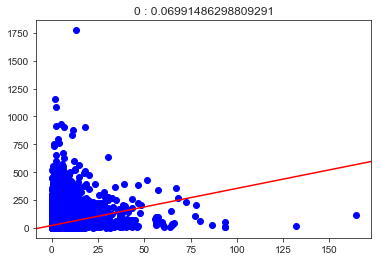

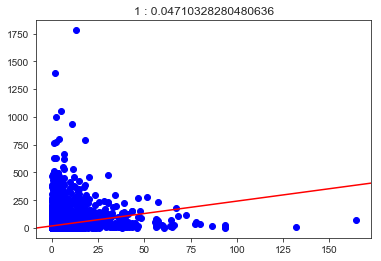

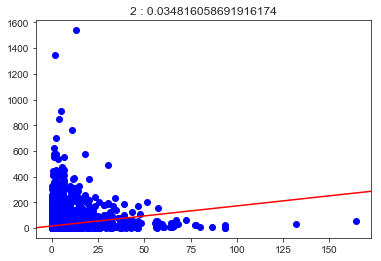

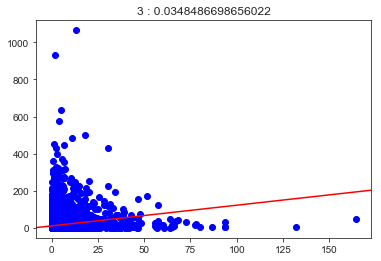

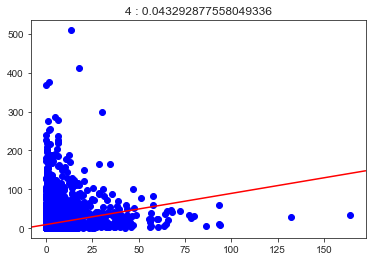

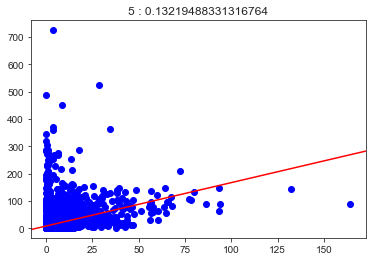

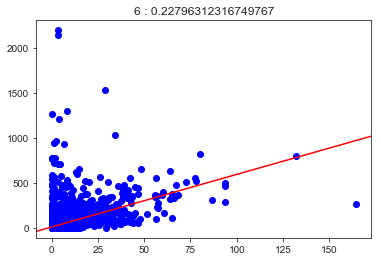

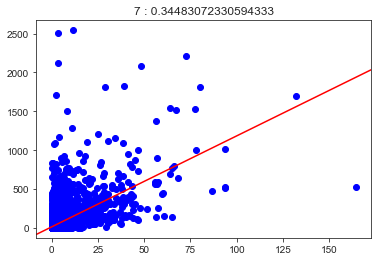

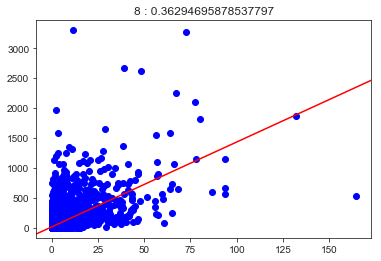

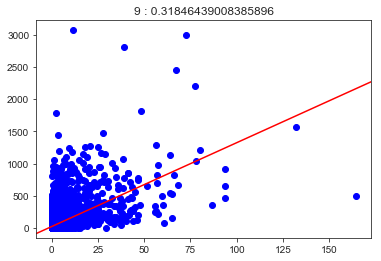

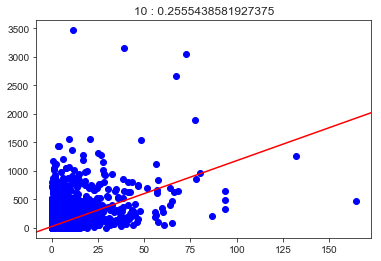

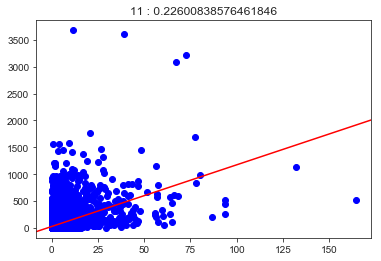

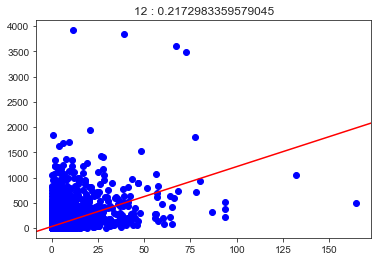

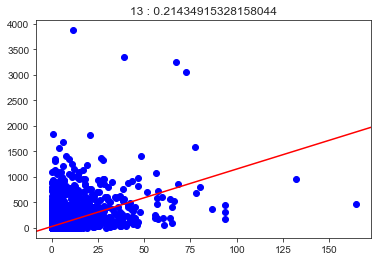

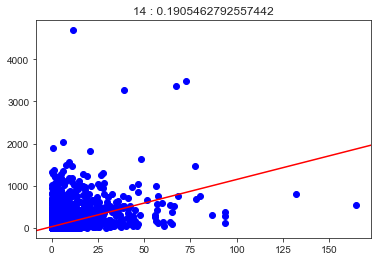

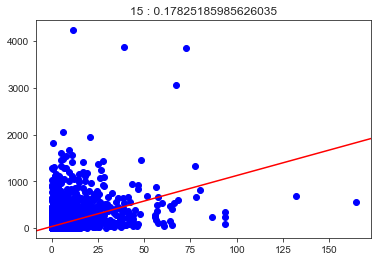

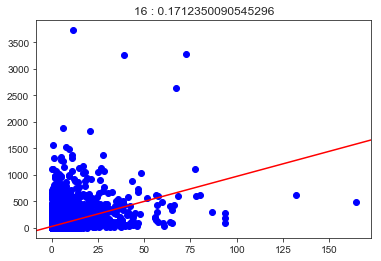

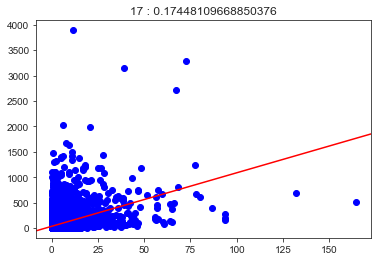

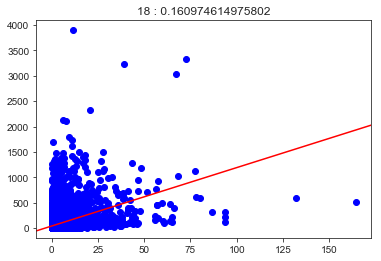

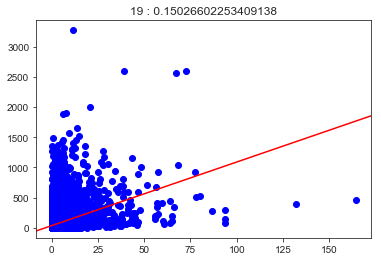

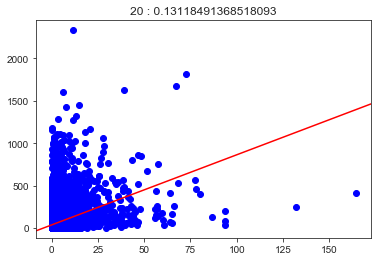

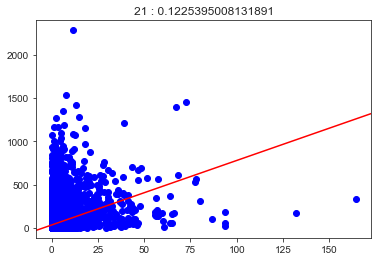

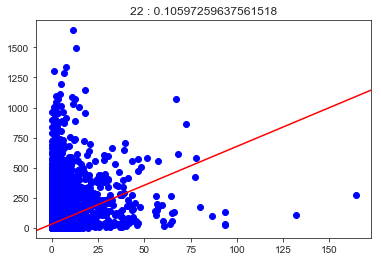

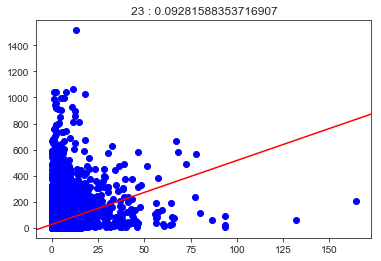

In [50]:
hrly_rsq = []
hrly_corr = []
for i in range(24):
    fig, ax = plt.subplots()
    hrdata = data[data['hour'] == i]
    plt.scatter('expected_taxi','counts', color='blue',data=hrdata)
    mod = smf.ols(formula='counts ~ expected_taxi', data = hrdata).fit()
    abline_plot(model_results=mod, ax=ax, color='red')
    plt.title('{} : {}'.format(i,mod.rsquared))
    hrly_rsq.append([i,mod.rsquared])
    hrly_corr.append([i,np.corrcoef(hrdata['expected_taxi'], hrdata['counts'])[1][0]]);

In [51]:
df_r = pd.DataFrame(hrly_rsq)
df_r.rename(columns={0:'hr',1:'r'},inplace=True)

df_corr = pd.DataFrame(hrly_corr)
df_corr.rename(columns={0:'hr',1:'corr_coef'},inplace=True)
df_corr

,hr,corr_coef
0,0,0.264414
1,1,0.217033
2,2,0.186591
3,3,0.186678
4,4,0.208069
5,5,0.363586
6,6,0.477455
7,7,0.587223
8,8,0.602451
9,9,0.564326


In [25]:
#!pip install -U seaborn

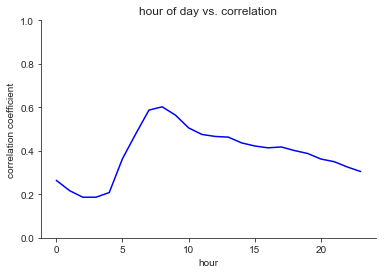

In [52]:
f, ax = plt.subplots()
sns.set_style("ticks")
sns.despine(f)
sns.lineplot(x="hr", y="corr_coef",color='b',
                data=df_corr, ax=ax)
plt.title('hour of day vs. correlation')
plt.xlabel('hour')
plt.ylabel('correlation coefficient')
ax.set_ylim(0,1);

## Hourly taxi ride counts vs total LODES count for each pair

/Users/katharinevoorhees/anaconda3/lib/python3.6/site-packages/matplotlib/pyplot.py:537: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


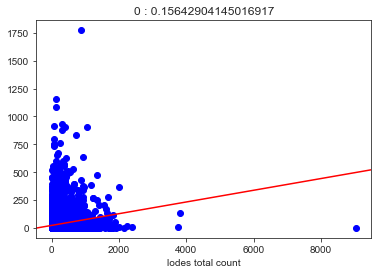

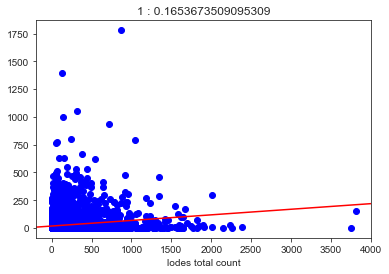

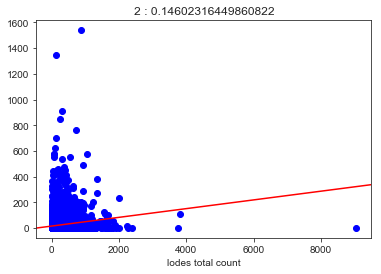

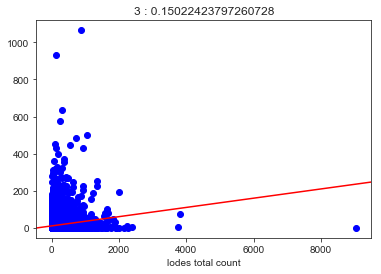

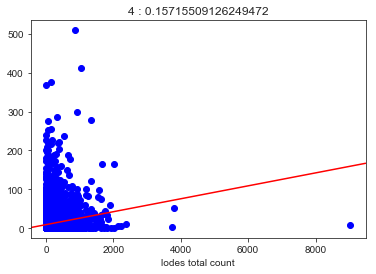

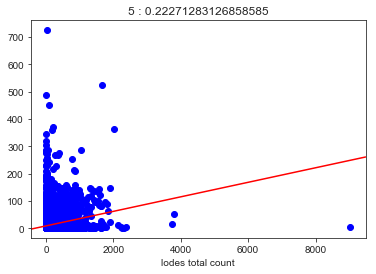

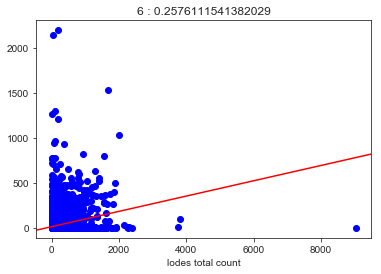

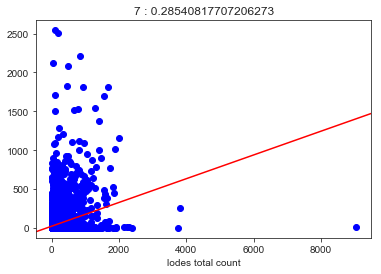

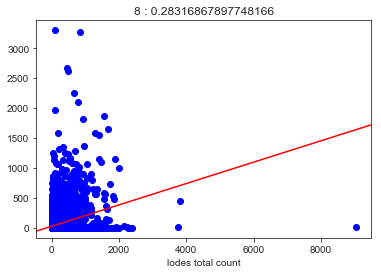

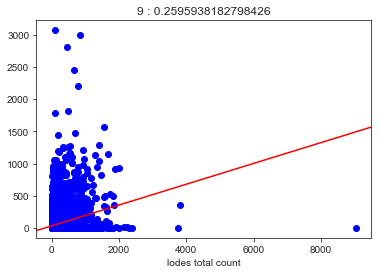

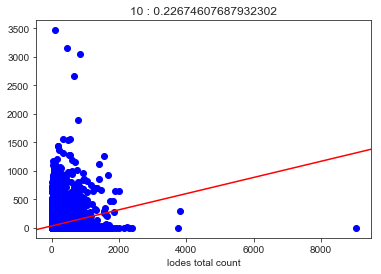

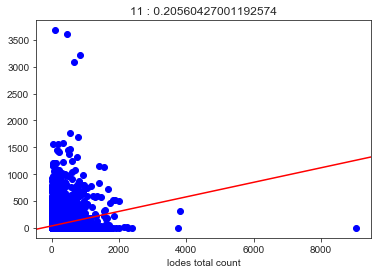

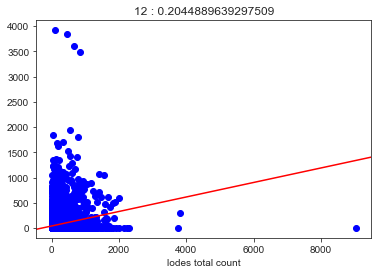

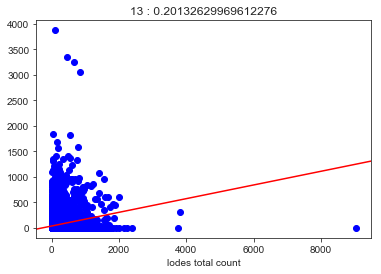

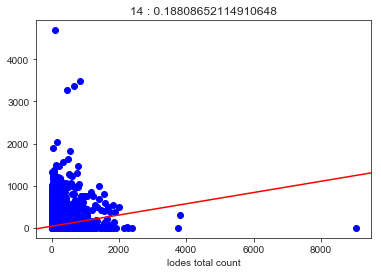

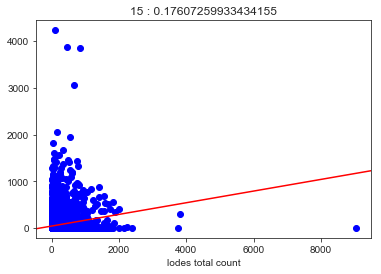

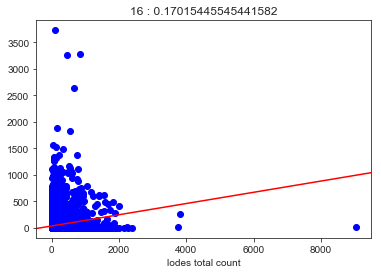

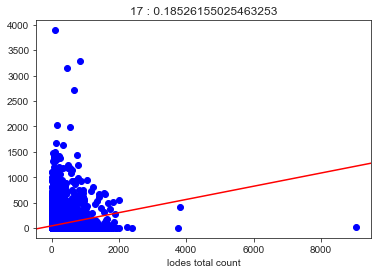

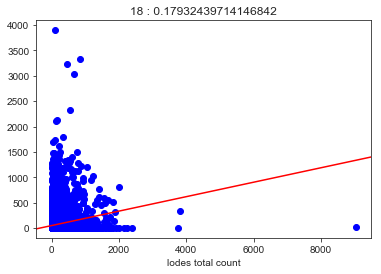

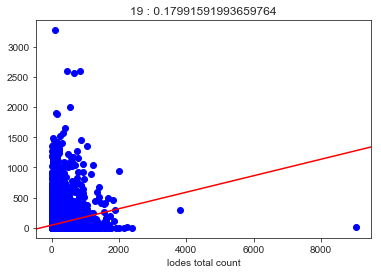

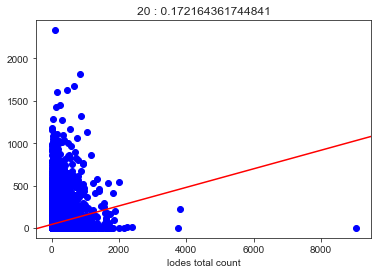

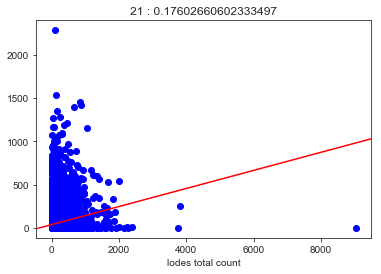

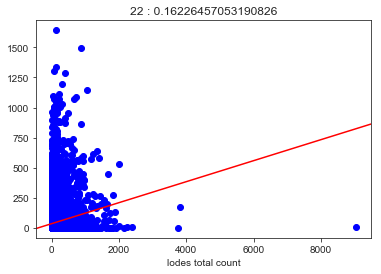

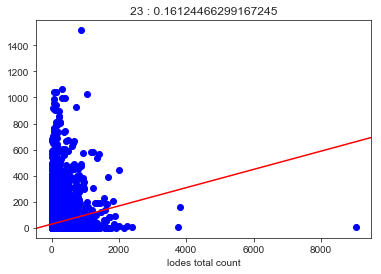

In [72]:
hrly_rsq2 = []
hrly_corr2 = []
for i in range(24):
    fig, ax = plt.subplots()
    hrdata = data[data['hour'] == i]
    plt.scatter('S000','counts', color='blue',data=hrdata)
    mod = smf.ols(formula='counts ~ S000', data = hrdata).fit()
    abline_plot(model_results=mod, ax=ax, color='red')
    plt.title('{} : {}'.format(i,
        np.corrcoef(hrdata['S000'], hrdata['counts'])[1][0]))
    plt.xlabel('lodes total count')
    hrly_rsq2.append([i,mod.rsquared])
    hrly_corr2.append([i,np.corrcoef(hrdata['S000'], hrdata['counts'])[1][0]])
    ;

In [73]:
df_r2 = pd.DataFrame(hrly_rsq2)
df_r2.rename(columns={0:'hr',1:'r'},inplace=True)

df_corr2 = pd.DataFrame(hrly_corr2)
df_corr2.rename(columns={0:'hr',1:'corr_coef'},inplace=True)
df_corr2

,hr,corr_coef
0,0,0.156429
1,1,0.165367
2,2,0.146023
3,3,0.150224
4,4,0.157155
5,5,0.222713
6,6,0.257611
7,7,0.285408
8,8,0.283169
9,9,0.259594


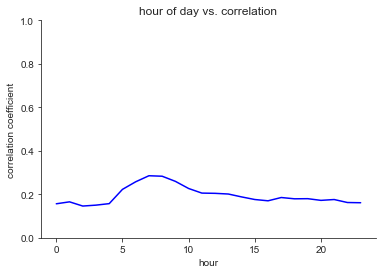

In [74]:
f, ax = plt.subplots()
sns.set_style("ticks")
sns.despine(f)
sns.lineplot(x="hr", y="corr_coef",color='b',
                data=df_corr2, ax=ax)
plt.title('hour of day vs. correlation')
plt.xlabel('hour')
plt.ylabel('correlation coefficient')
ax.set_ylim(0,1);